In [1]:
import execute_tensor as execute
from execute_tensor import execute as exe
from execute import tox_process

2023-12-31 00:26:00.729606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-31 00:26:00.899161: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-31 00:26:01.783694: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.3/lib64
2023-12-31 00:26:01.783785: W te

In [2]:
import os
import pickle

# 폴더 경로 설정
folder_path = './Final_data_token/CLS/'  # 해당 경로를 실제 폴더 경로로 바꿔주세요

# 빈 리스트 초기화
with open('./BERT/atomInSmile/1M_random_ZINC_word2index.pkl','rb') as file:
    word2idx = pickle.load(file)
data_sets = {}
# 폴더 내의 모든 .pkl 파일을 탐색
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'rb') as file:
        # .pkl 파일 열기
        data = pickle.load(file)
        print(data[1][0])
        print(file_path,len(data[0]))
    data_sets[filename] = data

tox_names = []
for filename in os.listdir(folder_path):
    tox_names.append(filename)

1
./Final_data_token/CLS/BBBP_vNN-ADMET 6696
1
./Final_data_token/CLS/Hepatotoxicity-Cytotoxicity-HepG2_vNN-ADMET 121906
1
./Final_data_token/CLS/CYP2C9_Inhibitor_vNN-ADMET 161017
1
./Final_data_token/CLS/CYP2C19_Inhibitor_vNN-ADMET 162656
1
./Final_data_token/CLS/CYP2D6_Inhibitor_vNN-ADMET 155682
1
./Final_data_token/CLS/HLM_metab_vNN-ADMET 64378
1
./Final_data_token/CLS/BBBP_MoleculeNet 40202
1
./Final_data_token/CLS/DILI_vNN-ADMET 27866
1
./Final_data_token/CLS/CYP1A2_Inhibitor_vNN-ADMET 150714
1
./Final_data_token/CLS/BBBP_MoleculeNet_clean 40201
1
./Final_data_token/CLS/CYP3A4_Inhibitor_vNN-ADMET 204188


In [3]:
import os
import pickle

# 폴더 경로 설정
folder_path = './Final_data_token_SMILE/CLS/'  # 해당 경로를 실제 폴더 경로로 바꿔주세요

# 빈 리스트 초기화
with open('./BERT/atomInSmile/1M_random_ZINC_word2index.pkl','rb') as file:
    word2idx = pickle.load(file)
data_sets_SMILE = {}
# 폴더 내의 모든 .pkl 파일을 탐색
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'rb') as file:
        # .pkl 파일 열기
        data = pickle.load(file)
        print(data[1][0])
        print(file_path,len(data[0]))
    data_sets_SMILE[filename]=data

tox_names = []
for filename in os.listdir(folder_path):
    tox_names.append(filename)

1
./Final_data_token_SMILE/CLS/BBBP_vNN-ADMET 6696
1
./Final_data_token_SMILE/CLS/Hepatotoxicity-Cytotoxicity-HepG2_vNN-ADMET 121907
1
./Final_data_token_SMILE/CLS/CYP2C9_Inhibitor_vNN-ADMET 161019
1
./Final_data_token_SMILE/CLS/CYP2C19_Inhibitor_vNN-ADMET 162651
1
./Final_data_token_SMILE/CLS/CYP2D6_Inhibitor_vNN-ADMET 155680
1
./Final_data_token_SMILE/CLS/HLM_metab_vNN-ADMET 64380
1
./Final_data_token_SMILE/CLS/BBBP_MoleculeNet 40204
1
./Final_data_token_SMILE/CLS/DILI_vNN-ADMET 27864
1
./Final_data_token_SMILE/CLS/CYP1A2_Inhibitor_vNN-ADMET 150716
1
./Final_data_token_SMILE/CLS/BBBP_MoleculeNet_clean 40197
1
./Final_data_token_SMILE/CLS/CYP3A4_Inhibitor_vNN-ADMET 204184


In [ ]:
import os
import pickle

# 폴더 경로 설정
folder_path = './Tox_data/AIS_Tox_data/'  # 해당 경로를 실제 폴더 경로로 바꿔주세요

data_sets = {}
# 폴더 내의 모든 .pkl 파일을 탐색
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'rb') as file:
        # .pkl 파일 열기
        data = pickle.load(file)
    data_sets[filename]=data[0]

tox_names = []
for filename in os.listdir(folder_path):
    tox_names.append(filename)

In [ ]:
import os
import pickle

# 폴더 경로 설정
folder_path = './Tox_data/SMILE_Tox_data/'  # 해당 경로를 실제 폴더 경로로 바꿔주세요

# 빈 리스트 초기화
with open('./BERT/atomInSmile/1M_random_ZINC_word2index.pkl','rb') as file:
    word2idx = pickle.load(file)
data_sets_SMILE = {}
# 폴더 내의 모든 .pkl 파일을 탐색
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    try:
        with open(file_path, 'rb') as file:
            # .pkl 파일 열기
            data = pickle.load(file)
    except:
        continue
    data_sets_SMILE[filename]=data[0]

tox_names = []
for filename in os.listdir(folder_path):
    tox_names.append(filename)

In [ ]:
data_sets_SMILE.keys()

dict_keys(['Carcinogens_Lagunin', 'DILI', 'ClinTox', 'LD50_Zhu', 'hERG', 'AMES', 'hERG_Karim', 'Skin Reaction'])

In [7]:
tox_names

['Carcinogens_Lagunin',
 'DILI',
 'ClinTox',
 'LD50_Zhu',
 'hERG',
 'AMES',
 'hERG_Karim',
 'Skin Reaction',
 'Tox_cast']

In [4]:
import os
import pickle
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from Module import RDK
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# 폴더 경로 설정
folder_path = './Final_data/CLS/'  # 해당 경로를 실제 폴더 경로로 바꿔주세요

data_list = ['Smiles','smiles','SMILES']
label_list = ['Property','p_np']
# 빈 리스트 초기화
with open('./BERT/atomInSmile/1M_random_ZINC_word2index.pkl','rb') as file:
    word2idx = pickle.load(file)
data_sets_bit = {}
# 폴더 내의 모든 .pkl 파일을 탐색
plot_index = 1
for filename in os.listdir(folder_path):
    plt.figure(figsize=(8, 12))
    print(filename)
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'r') as file:
        data = pd.read_csv(file)
        
        for name in data_list:
            try:
                train = data[name]
                print('data pass')
                break
            except:
                pass
            
        for name in label_list:
            try:
                label = data[name]
                print('label pass')
                break
            except:
                pass
        corpus = list(zip(train,label))
        train = []
        label = []
        for index,temp in enumerate(corpus):
            try:
                train.append(RDK.smile_to_RDkit([temp[0]],2048)[0])
                label.append(temp[1])
            except:
                pass
        colors = {1:'red',0:'blue'}
        reduced_data = pca.fit_transform(train)
        corpus = train_test_split(train,label,test_size=0.2,random_state=52)
        red,red_val = train_test_split(reduced_data,test_size=0.2,random_state=52)
        """
        plt.subplot(211)
        plt.scatter(red[:,0], red[:,1], c=[colors[label] for label in corpus[2]],s=1)
        

        plt.subplot(212)
        plt.scatter(red_val[:,0], red_val[:,1], c=[colors[label] for label in corpus[3]],s=1)
        plt.show()"""
        
    data_sets_bit[filename[:-4]] = corpus

tox_names = []
for filename in os.listdir(folder_path):
    tox_names.append(filename)

BBBP_vNN-ADMET.csv
data pass
label pass
BBBP_MoleculeNet_clean.csv
data pass
label pass


[00:26:21] Explicit valence for atom # 1 N, 4, is greater than permitted
[00:26:21] Explicit valence for atom # 6 N, 4, is greater than permitted
[00:26:21] Explicit valence for atom # 6 N, 4, is greater than permitted
[00:26:21] Explicit valence for atom # 11 N, 4, is greater than permitted
[00:26:21] Explicit valence for atom # 12 N, 4, is greater than permitted
[00:26:21] Explicit valence for atom # 5 N, 4, is greater than permitted
[00:26:21] Explicit valence for atom # 5 N, 4, is greater than permitted
[00:26:21] Explicit valence for atom # 5 N, 4, is greater than permitted
[00:26:21] Explicit valence for atom # 5 N, 4, is greater than permitted
[00:26:21] Explicit valence for atom # 5 N, 4, is greater than permitted
[00:26:21] Explicit valence for atom # 5 N, 4, is greater than permitted


DILI_vNN-ADMET.csv
data pass
label pass
CYP2C19_Inhibitor_vNN-ADMET.csv
data pass
label pass


[00:26:26] SMILES Parse Error: syntax error while parsing: c1ccc2c(c1)[i+]c3ccccc23
[00:26:26] SMILES Parse Error: Failed parsing SMILES 'c1ccc2c(c1)[i+]c3ccccc23' for input: 'c1ccc2c(c1)[i+]c3ccccc23'


CYP3A4_Inhibitor_vNN-ADMET.csv
data pass
label pass


[00:26:35] SMILES Parse Error: syntax error while parsing: c1ccc2c(c1)[i+]c3ccccc23
[00:26:35] SMILES Parse Error: Failed parsing SMILES 'c1ccc2c(c1)[i+]c3ccccc23' for input: 'c1ccc2c(c1)[i+]c3ccccc23'


CYP2D6_Inhibitor_vNN-ADMET.csv
data pass
label pass


[00:26:44] SMILES Parse Error: syntax error while parsing: c1ccc2c(c1)[i+]c3ccccc23
[00:26:44] SMILES Parse Error: Failed parsing SMILES 'c1ccc2c(c1)[i+]c3ccccc23' for input: 'c1ccc2c(c1)[i+]c3ccccc23'


Hepatotoxicity-Cytotoxicity-HepG2_vNN-ADMET.csv
data pass
label pass
CYP1A2_Inhibitor_vNN-ADMET.csv
data pass
label pass


[00:26:58] SMILES Parse Error: syntax error while parsing: c1ccc2c(c1)[i+]c3ccccc23
[00:26:58] SMILES Parse Error: Failed parsing SMILES 'c1ccc2c(c1)[i+]c3ccccc23' for input: 'c1ccc2c(c1)[i+]c3ccccc23'


BBBP_MoleculeNet.csv
data pass
label pass


[00:27:05] Explicit valence for atom # 1 N, 4, is greater than permitted
[00:27:05] WARNING: not removing hydrogen atom without neighbors
[00:27:05] Explicit valence for atom # 6 N, 4, is greater than permitted
[00:27:05] WARNING: not removing hydrogen atom without neighbors
[00:27:05] WARNING: not removing hydrogen atom without neighbors
[00:27:05] WARNING: not removing hydrogen atom without neighbors
[00:27:05] WARNING: not removing hydrogen atom without neighbors
[00:27:05] WARNING: not removing hydrogen atom without neighbors
[00:27:05] WARNING: not removing hydrogen atom without neighbors
[00:27:05] Explicit valence for atom # 6 N, 4, is greater than permitted
[00:27:05] WARNING: not removing hydrogen atom without neighbors
[00:27:06] WARNING: not removing hydrogen atom without neighbors
[00:27:06] WARNING: not removing hydrogen atom without neighbors
[00:27:06] WARNING: not removing hydrogen atom without neighbors
[00:27:06] Explicit valence for atom # 11 N, 4, is greater than pe

CYP2C9_Inhibitor_vNN-ADMET.csv
data pass
label pass


[00:27:08] SMILES Parse Error: syntax error while parsing: c1ccc2c(c1)[i+]c3ccccc23
[00:27:08] SMILES Parse Error: Failed parsing SMILES 'c1ccc2c(c1)[i+]c3ccccc23' for input: 'c1ccc2c(c1)[i+]c3ccccc23'


HLM_metab_vNN-ADMET.csv
data pass
label pass


<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

In [5]:
data_sets_bit.keys()

dict_keys(['BBBP_vNN-ADMET', 'BBBP_MoleculeNet_clean', 'DILI_vNN-ADMET', 'CYP2C19_Inhibitor_vNN-ADMET', 'CYP3A4_Inhibitor_vNN-ADMET', 'CYP2D6_Inhibitor_vNN-ADMET', 'Hepatotoxicity-Cytotoxicity-HepG2_vNN-ADMET', 'CYP1A2_Inhibitor_vNN-ADMET', 'BBBP_MoleculeNet', 'CYP2C9_Inhibitor_vNN-ADMET', 'HLM_metab_vNN-ADMET'])

In [6]:
data_sets.keys()

dict_keys(['BBBP_vNN-ADMET', 'Hepatotoxicity-Cytotoxicity-HepG2_vNN-ADMET', 'CYP2C9_Inhibitor_vNN-ADMET', 'CYP2C19_Inhibitor_vNN-ADMET', 'CYP2D6_Inhibitor_vNN-ADMET', 'HLM_metab_vNN-ADMET', 'BBBP_MoleculeNet', 'DILI_vNN-ADMET', 'CYP1A2_Inhibitor_vNN-ADMET', 'BBBP_MoleculeNet_clean', 'CYP3A4_Inhibitor_vNN-ADMET'])

In [7]:
from execute_tensor import execute as exe

In [8]:
tox_execute_Bit = exe(test_size=0.2,split_seed=42,epoch=30,batch=32,tokens=['SMILE'])

CYP2C9_Inhibitor_vNN-ADMET


Epoch 1/10


2023-12-31 00:27:50.387591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-31 00:27:50.469485: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f89bc09cf00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-31 00:27:50.469544: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-12-31 00:27:50.483378: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-31 00:27:50.636522: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4026/4026 [==============================] - 734s 174ms/step - loss: 0.2868 - acc: 0.8901 - auc: 0.8201
Epoch 2/10
4026/4026 [==============================] - 695s 173ms/step - loss: 0.2189 - acc: 0.9125 - auc: 0.9055
Epoch 3/10
4026/4026 [==============================] - 696s 173ms/step - loss: 0.1755 - acc: 0.9296 - auc: 0.9427
Epoch 4/10
4026/4026 [==============================] - 695s 173ms/step - loss: 0.1406 - acc: 0.9434 - auc: 0.9655
Epoch 5/10
4026/4026 [==============================] - 695s 173ms/step - loss: 0.1145 - acc: 0.9527 - auc: 0.9780
Epoch 6/10
4026/4026 [==============================] - 695s 173ms/step - loss: 0.0941 - acc: 0.9615 - auc: 0.9852
Epoch 7/10
4026/4026 [==============================] - 694s 172ms/step - loss: 0.0785 - acc: 0.9682 - auc: 0.9898
Epoch 8/10
4026/4026 [==============================] - 692s 172ms/step - loss: 0.0673 - acc: 0.9725 - auc: 0.9922
Epoch 9/10
4026/4026 [==============================] - 694s 172ms/step - loss: 0.0587 - ac

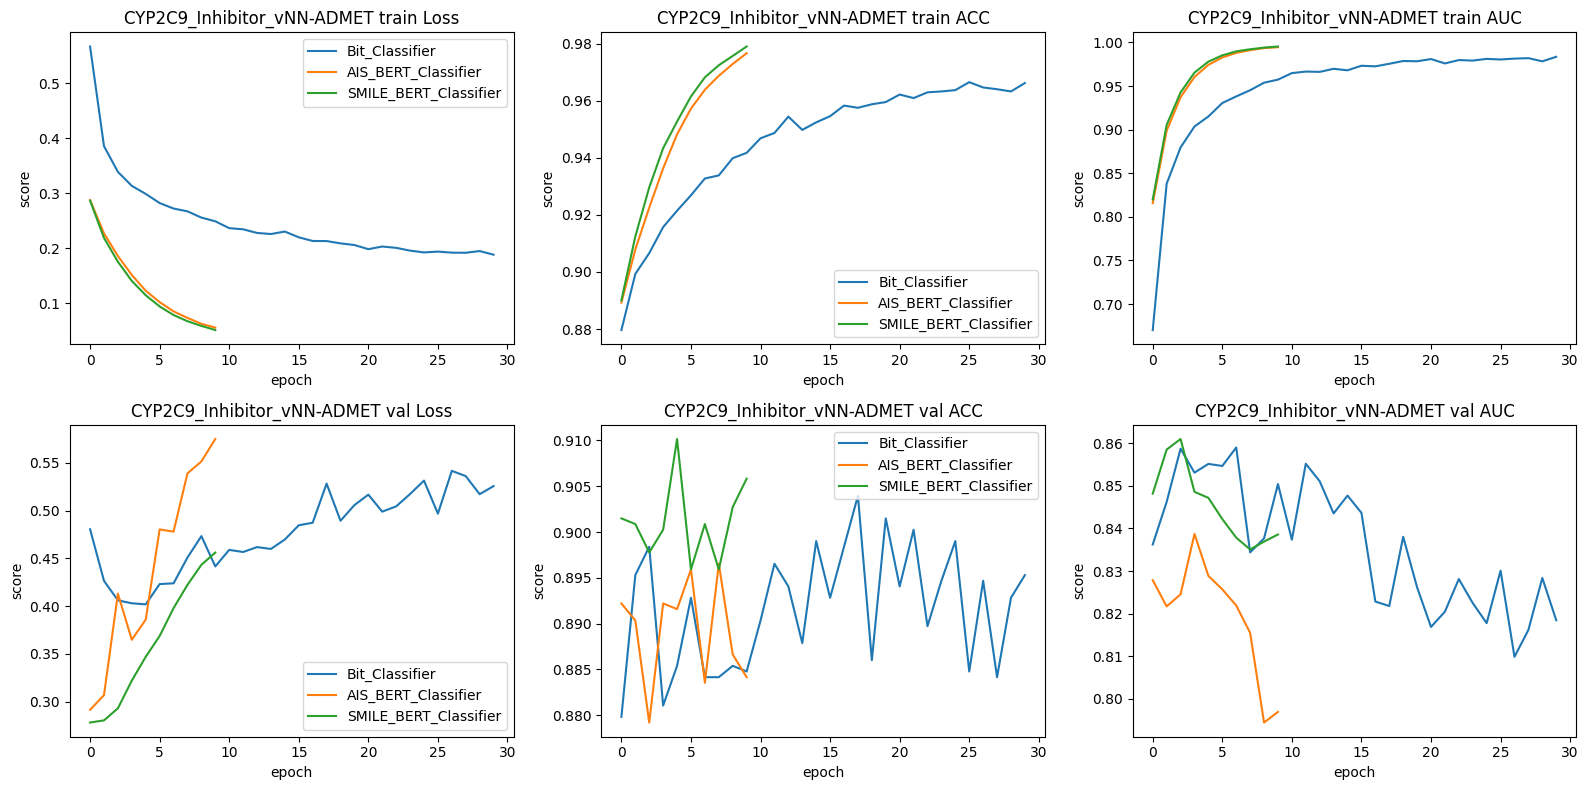

CYP2C19_Inhibitor_vNN-ADMET
Epoch 1/10
4066/4066 [==============================] - 743s 174ms/step - loss: 0.3634 - acc: 0.8487 - auc: 0.8319
Epoch 2/10
4066/4066 [==============================] - 704s 173ms/step - loss: 0.2912 - acc: 0.8798 - auc: 0.8966
Epoch 3/10
4066/4066 [==============================] - 703s 173ms/step - loss: 0.2487 - acc: 0.8989 - auc: 0.9268
Epoch 4/10
4066/4066 [==============================] - 705s 173ms/step - loss: 0.2108 - acc: 0.9140 - auc: 0.9493
Epoch 5/10
4066/4066 [==============================] - 703s 173ms/step - loss: 0.1772 - acc: 0.9279 - auc: 0.9651
Epoch 6/10
4066/4066 [==============================] - 702s 173ms/step - loss: 0.1512 - acc: 0.9382 - auc: 0.9752
Epoch 7/10
4066/4066 [==============================] - 702s 173ms/step - loss: 0.1293 - acc: 0.9470 - auc: 0.9821
Epoch 8/10
4066/4066 [==============================] - 704s 173ms/step - loss: 0.1111 - acc: 0.9544 - auc: 0.9865
Epoch 9/10
4066/4066 [==============================

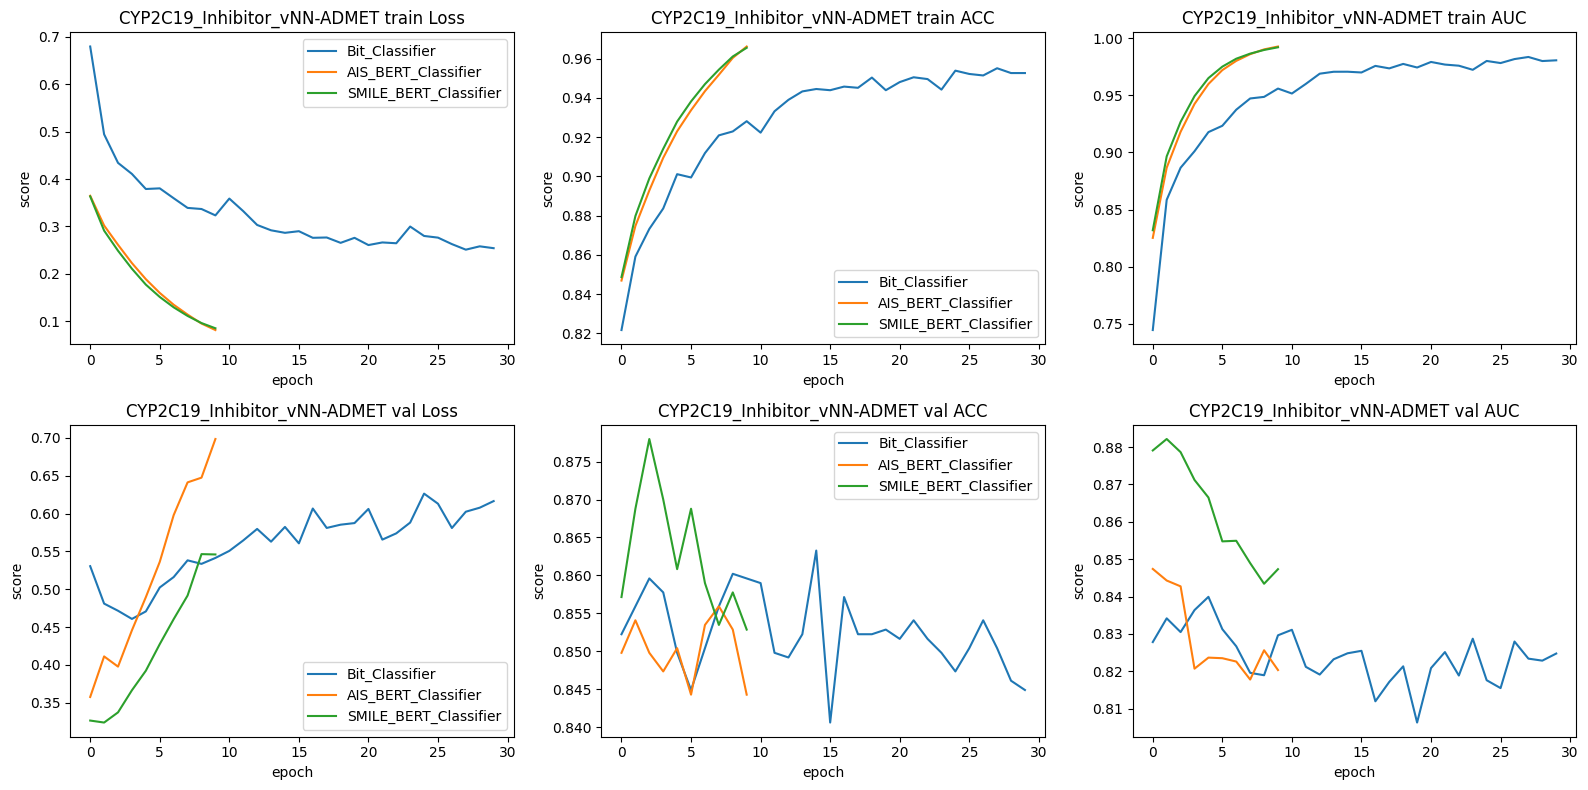

CYP2D6_Inhibitor_vNN-ADMET
Epoch 1/10
3892/3892 [==============================] - 709s 174ms/step - loss: 0.3207 - acc: 0.8678 - auc: 0.8513
Epoch 2/10
3892/3892 [==============================] - 672s 173ms/step - loss: 0.2475 - acc: 0.8996 - auc: 0.9159
Epoch 3/10
3892/3892 [==============================] - 672s 173ms/step - loss: 0.2072 - acc: 0.9169 - auc: 0.9437
Epoch 4/10
3892/3892 [==============================] - 671s 172ms/step - loss: 0.1730 - acc: 0.9292 - auc: 0.9622
Epoch 5/10
3892/3892 [==============================] - 674s 173ms/step - loss: 0.1444 - acc: 0.9410 - auc: 0.9741
Epoch 6/10
3892/3892 [==============================] - 671s 172ms/step - loss: 0.1221 - acc: 0.9495 - auc: 0.9819
Epoch 7/10
3892/3892 [==============================] - 672s 173ms/step - loss: 0.1055 - acc: 0.9563 - auc: 0.9865
Epoch 8/10
3892/3892 [==============================] - 674s 173ms/step - loss: 0.0911 - acc: 0.9626 - auc: 0.9898
Epoch 9/10
3892/3892 [==============================]

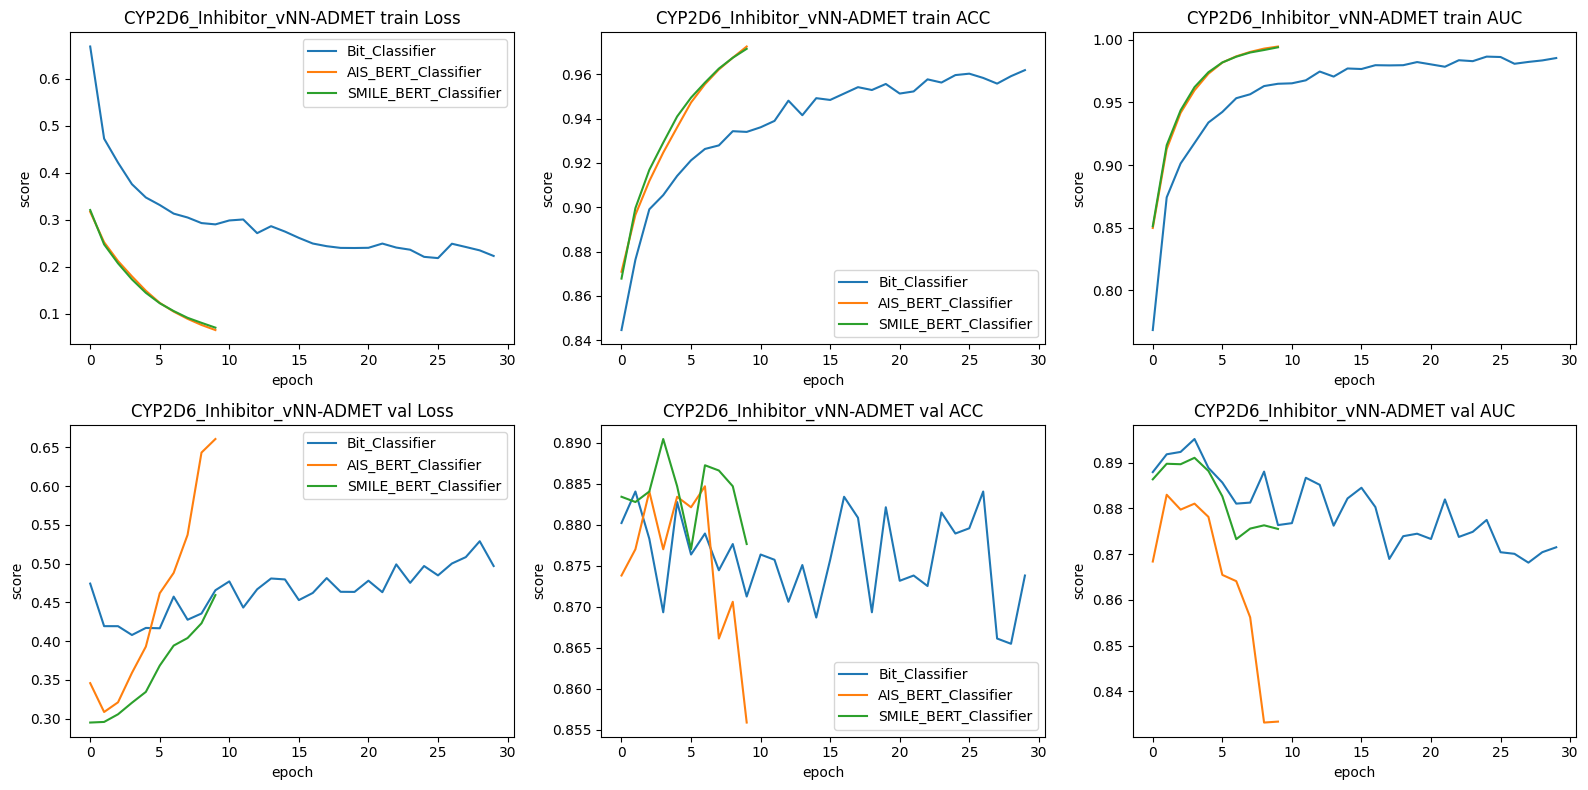

HLM_metab_vNN-ADMET
Epoch 1/10
1610/1610 [==============================] - 313s 174ms/step - loss: 0.6159 - acc: 0.6790 - auc: 0.6950
Epoch 2/10
1610/1610 [==============================] - 278s 173ms/step - loss: 0.4832 - acc: 0.7687 - auc: 0.8297
Epoch 3/10
1610/1610 [==============================] - 279s 173ms/step - loss: 0.4101 - acc: 0.8097 - auc: 0.8817
Epoch 4/10
1610/1610 [==============================] - 278s 173ms/step - loss: 0.3544 - acc: 0.8421 - auc: 0.9134
Epoch 5/10
1610/1610 [==============================] - 278s 173ms/step - loss: 0.3102 - acc: 0.8647 - auc: 0.9344
Epoch 6/10
1610/1610 [==============================] - 278s 173ms/step - loss: 0.2683 - acc: 0.8853 - auc: 0.9512
Epoch 7/10
1610/1610 [==============================] - 279s 173ms/step - loss: 0.2361 - acc: 0.9011 - auc: 0.9624
Epoch 8/10
1610/1610 [==============================] - 279s 173ms/step - loss: 0.2079 - acc: 0.9135 - auc: 0.9708
Epoch 9/10
1610/1610 [==============================] - 279s

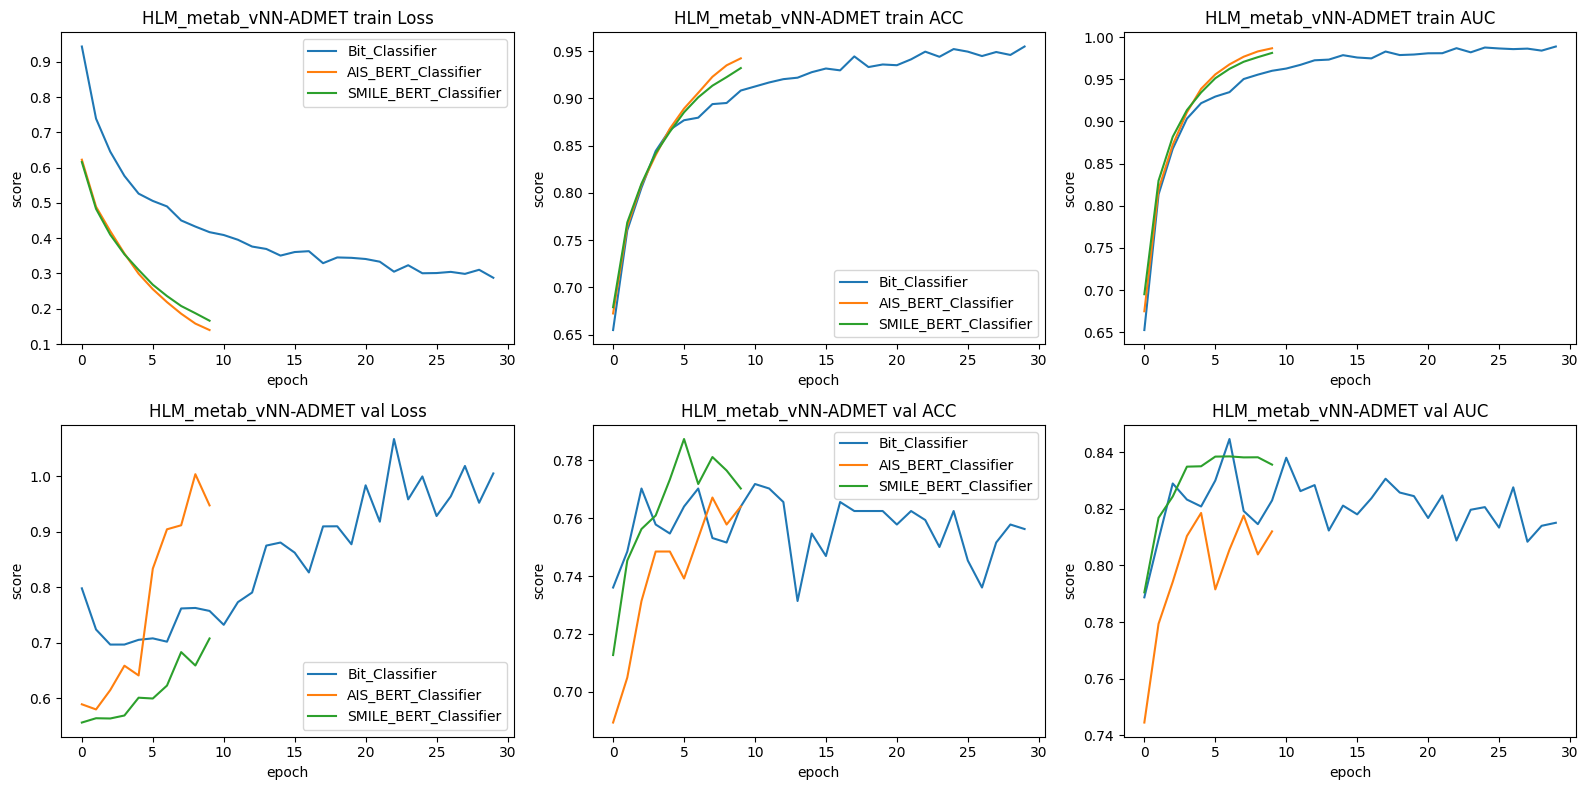

BBBP_MoleculeNet
Epoch 1/10
1006/1006 [==============================] - 212s 178ms/step - loss: 0.3478 - acc: 0.8592 - auc: 0.8788
Epoch 2/10
1006/1006 [==============================] - 175s 174ms/step - loss: 0.2350 - acc: 0.9092 - auc: 0.9479
Epoch 3/10
1006/1006 [==============================] - 173s 172ms/step - loss: 0.1659 - acc: 0.9363 - auc: 0.9748
Epoch 4/10
1006/1006 [==============================] - 175s 174ms/step - loss: 0.1189 - acc: 0.9549 - auc: 0.9868
Epoch 5/10
1006/1006 [==============================] - 174s 173ms/step - loss: 0.0887 - acc: 0.9672 - auc: 0.9926
Epoch 6/10
1006/1006 [==============================] - 173s 172ms/step - loss: 0.0661 - acc: 0.9761 - auc: 0.9957
Epoch 7/10
1006/1006 [==============================] - 174s 173ms/step - loss: 0.0499 - acc: 0.9815 - auc: 0.9976
Epoch 8/10
1006/1006 [==============================] - 174s 173ms/step - loss: 0.0405 - acc: 0.9846 - auc: 0.9982
Epoch 9/10
1006/1006 [==============================] - 174s 17

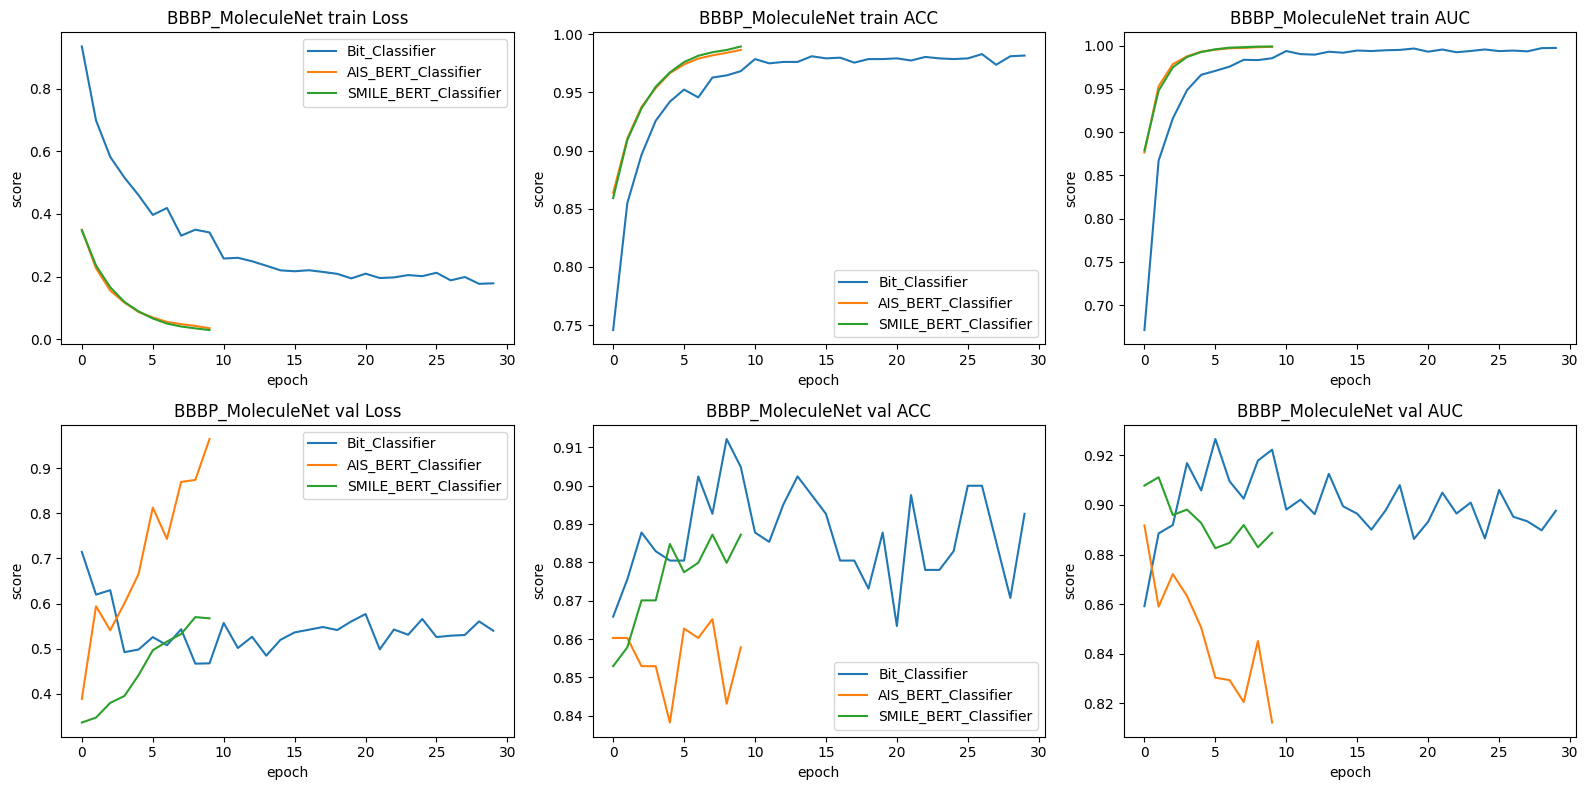

DILI_vNN-ADMET
Epoch 1/10
697/697 [==============================] - 159s 180ms/step - loss: 0.6934 - acc: 0.6232 - auc: 0.6624
Epoch 2/10
697/697 [==============================] - 122s 176ms/step - loss: 0.5992 - acc: 0.6929 - auc: 0.7536
Epoch 3/10
697/697 [==============================] - 122s 175ms/step - loss: 0.5263 - acc: 0.7416 - auc: 0.8155
Epoch 4/10
697/697 [==============================] - 122s 175ms/step - loss: 0.4581 - acc: 0.7833 - auc: 0.8636
Epoch 5/10
697/697 [==============================] - 122s 175ms/step - loss: 0.3994 - acc: 0.8151 - auc: 0.8986
Epoch 6/10
697/697 [==============================] - 121s 173ms/step - loss: 0.3384 - acc: 0.8489 - auc: 0.9284
Epoch 7/10
697/697 [==============================] - 122s 175ms/step - loss: 0.2893 - acc: 0.8720 - auc: 0.9481
Epoch 8/10
697/697 [==============================] - 121s 174ms/step - loss: 0.2455 - acc: 0.8961 - auc: 0.9630
Epoch 9/10
697/697 [==============================] - 121s 174ms/step - loss: 0.2

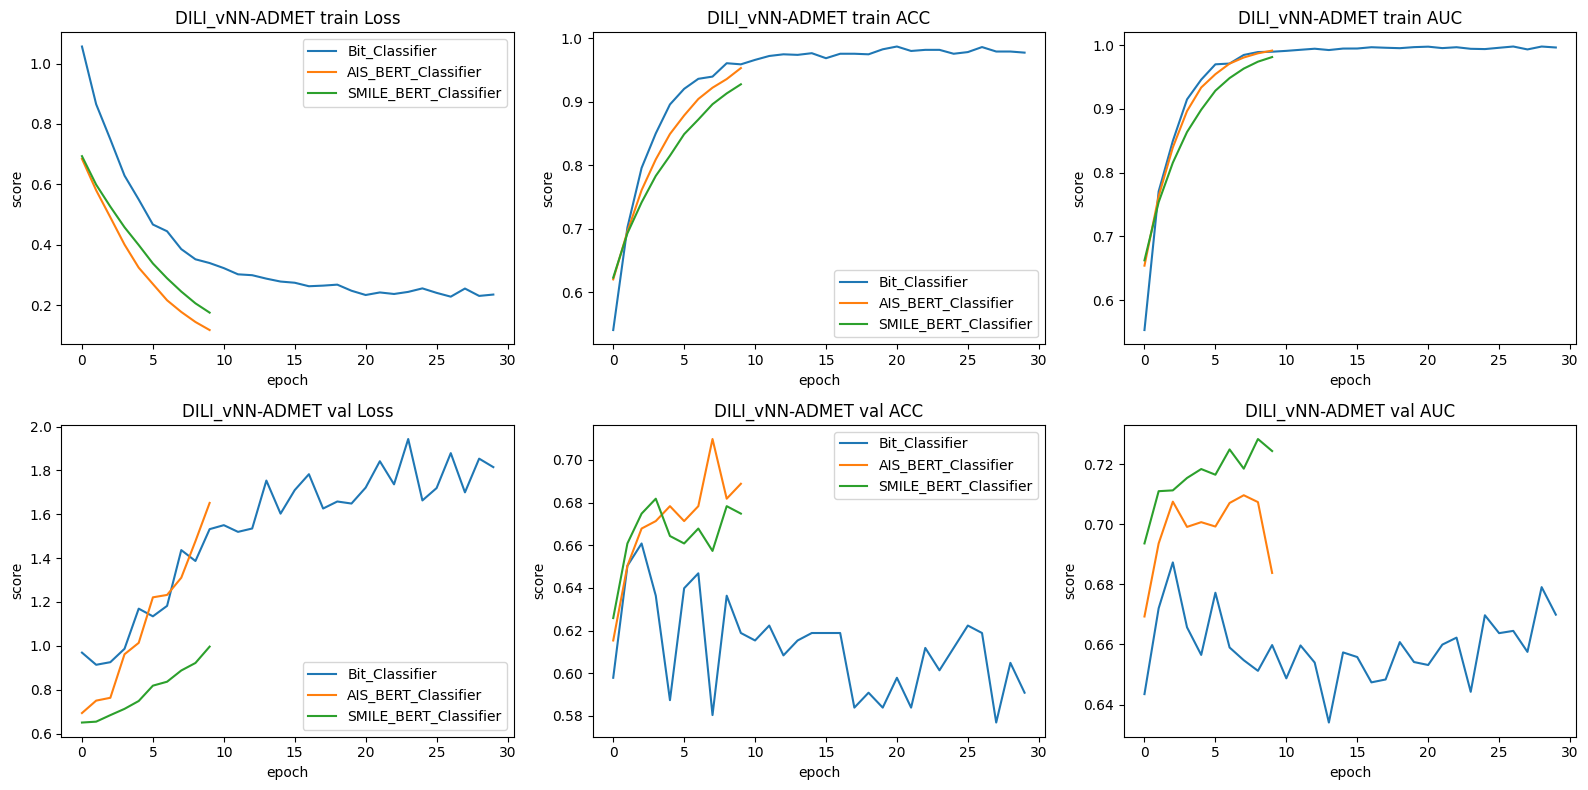

CYP1A2_Inhibitor_vNN-ADMET
Epoch 1/10
3768/3768 [==============================] - 688s 174ms/step - loss: 0.3018 - acc: 0.8668 - auc: 0.8904
Epoch 2/10
3768/3768 [==============================] - 654s 173ms/step - loss: 0.2231 - acc: 0.9021 - auc: 0.9423
Epoch 3/10
3768/3768 [==============================] - 654s 173ms/step - loss: 0.1800 - acc: 0.9233 - auc: 0.9633
Epoch 4/10
3768/3768 [==============================] - 654s 173ms/step - loss: 0.1467 - acc: 0.9392 - auc: 0.9758
Epoch 5/10
3768/3768 [==============================] - 655s 174ms/step - loss: 0.1213 - acc: 0.9504 - auc: 0.9835
Epoch 6/10
3768/3768 [==============================] - 655s 174ms/step - loss: 0.1016 - acc: 0.9589 - auc: 0.9884
Epoch 7/10
3768/3768 [==============================] - 651s 173ms/step - loss: 0.0869 - acc: 0.9648 - auc: 0.9915
Epoch 8/10
3768/3768 [==============================] - 653s 173ms/step - loss: 0.0742 - acc: 0.9701 - auc: 0.9938
Epoch 9/10
3768/3768 [==============================]

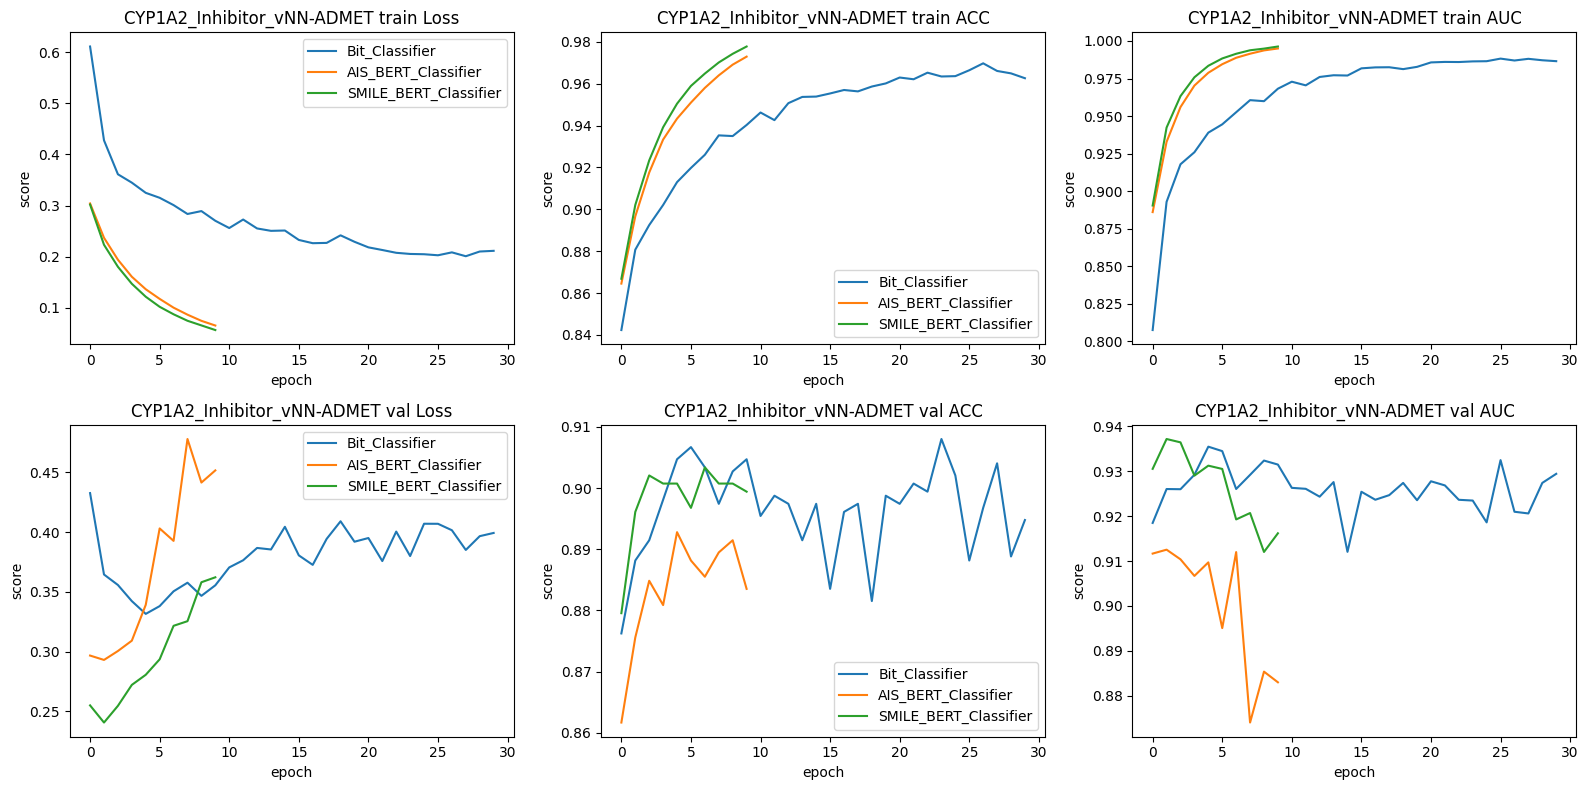

BBBP_MoleculeNet_clean
Epoch 1/10
1006/1006 [==============================] - 210s 176ms/step - loss: 0.3673 - acc: 0.8531 - auc: 0.8631
Epoch 2/10
1006/1006 [==============================] - 175s 174ms/step - loss: 0.2471 - acc: 0.9035 - auc: 0.9426
Epoch 3/10
1006/1006 [==============================] - 173s 172ms/step - loss: 0.1803 - acc: 0.9320 - auc: 0.9699
Epoch 4/10
1006/1006 [==============================] - 174s 173ms/step - loss: 0.1327 - acc: 0.9510 - auc: 0.9835
Epoch 5/10
1006/1006 [==============================] - 174s 173ms/step - loss: 0.0988 - acc: 0.9630 - auc: 0.9909
Epoch 6/10
1006/1006 [==============================] - 173s 172ms/step - loss: 0.0731 - acc: 0.9732 - auc: 0.9947
Epoch 7/10
1006/1006 [==============================] - 174s 173ms/step - loss: 0.0568 - acc: 0.9799 - auc: 0.9967
Epoch 8/10
1006/1006 [==============================] - 173s 172ms/step - loss: 0.0443 - acc: 0.9839 - auc: 0.9979
Epoch 9/10
1006/1006 [==============================] - 1

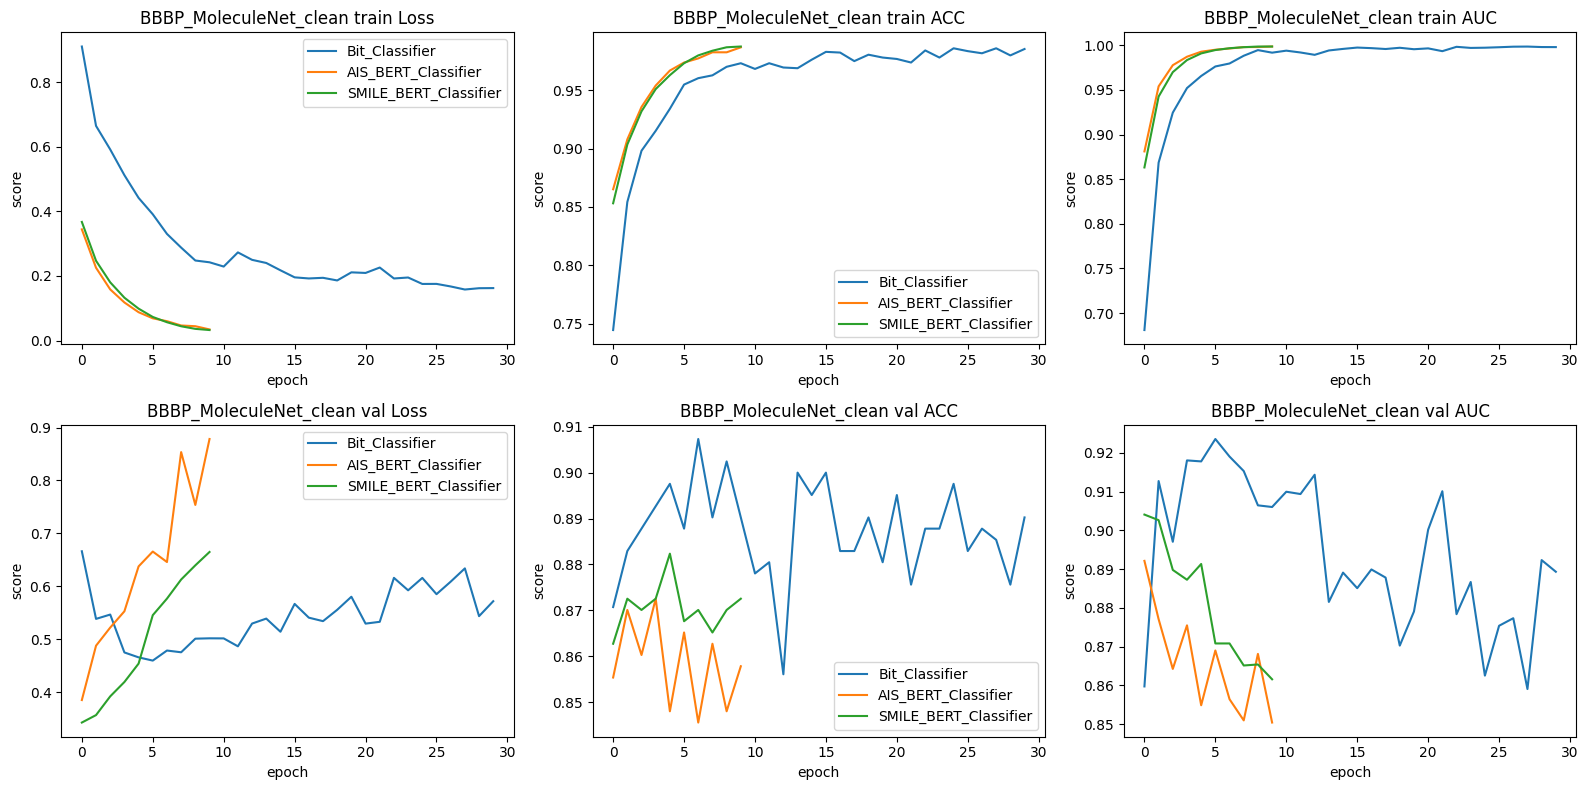

CYP3A4_Inhibitor_vNN-ADMET
Epoch 1/10
5107/5107 [==============================] - 922s 174ms/step - loss: 0.3375 - acc: 0.8490 - auc: 0.8942
Epoch 2/10
5107/5107 [==============================] - 882s 173ms/step - loss: 0.2428 - acc: 0.8951 - auc: 0.9473
Epoch 3/10
5107/5107 [==============================] - 883s 173ms/step - loss: 0.1938 - acc: 0.9176 - auc: 0.9671
Epoch 4/10
5107/5107 [==============================] - 882s 173ms/step - loss: 0.1594 - acc: 0.9333 - auc: 0.9779
Epoch 5/10
5107/5107 [==============================] - 887s 174ms/step - loss: 0.1343 - acc: 0.9438 - auc: 0.9843
Epoch 6/10
5107/5107 [==============================] - 885s 173ms/step - loss: 0.1128 - acc: 0.9539 - auc: 0.9889
Epoch 7/10
5107/5107 [==============================] - 883s 173ms/step - loss: 0.0965 - acc: 0.9608 - auc: 0.9918
Epoch 8/10
5107/5107 [==============================] - 883s 173ms/step - loss: 0.0846 - acc: 0.9656 - auc: 0.9936
Epoch 9/10
5107/5107 [==============================]

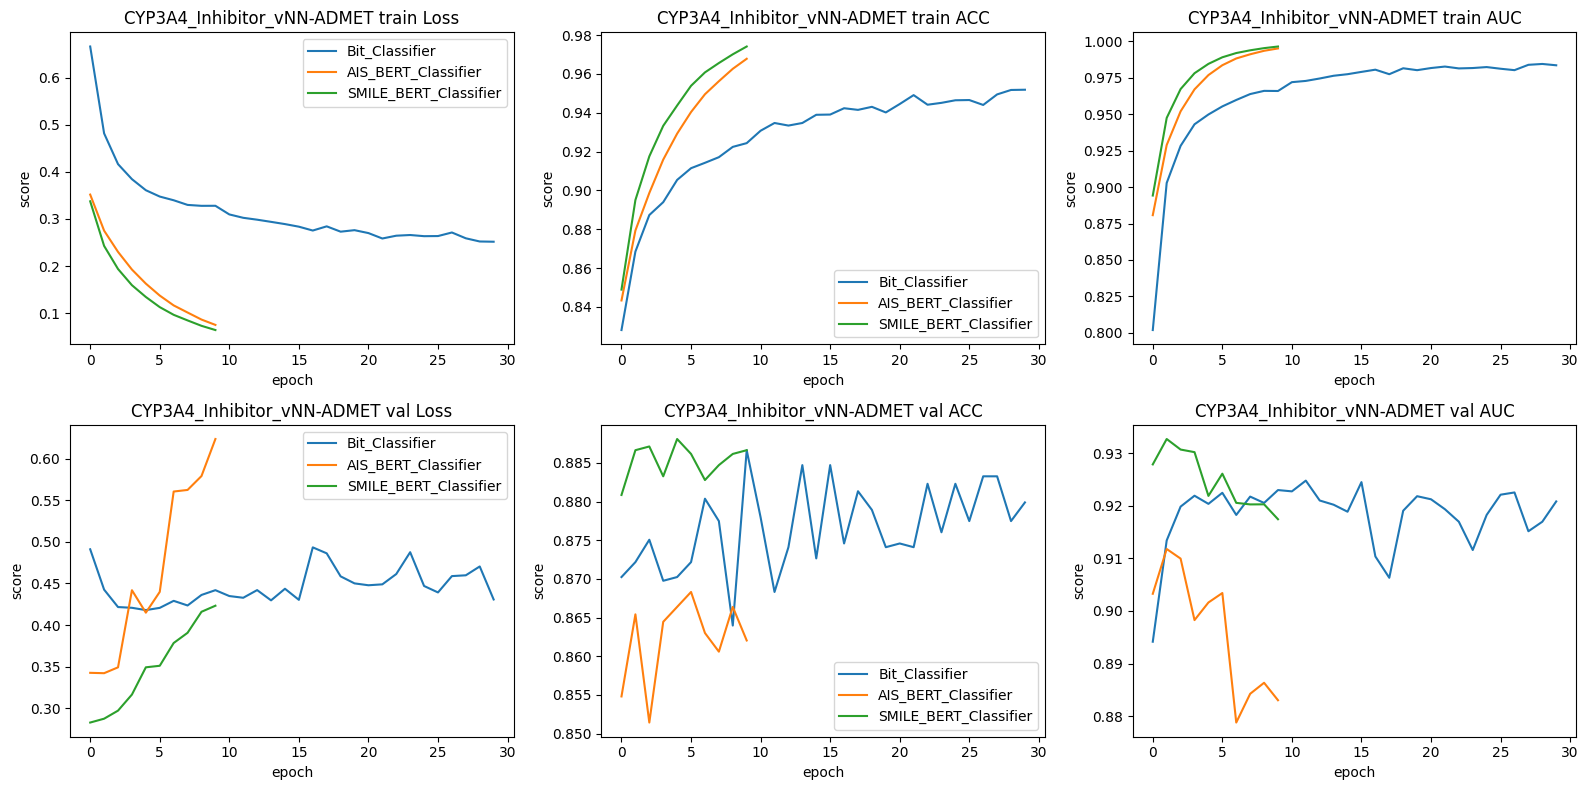

In [8]:

tokens = ['AIS','SMILE']
BERT_names = []

with open('./BERT/SMILE/1M_random_ZINC_word2index.pkl','rb') as file:
    word2idx_SMILE = pickle.load(file)

for token in tokens:
    BERT_names.append(token+"_BERT_Classifier")

for index,tox_name in enumerate(data_sets.keys()):
    if index == 0 or index == 1 :
        continue
    print(tox_name)
    tox_execute_AIS = exe(test_size=0.2,split_seed=42,epoch=10,batch=32,tokens=['AIS'])
    tox_execute_SMILE = exe(test_size=0.2,split_seed=42,epoch=10,batch=32,tokens=['SMILE'])
    tox_execute_Bit = exe(test_size=0.2,split_seed=42,epoch=30,batch=32,tokens=['SMILE'])
    tox_execute_SMILE.forward(data_sets_SMILE[tox_name],word2idx_SMILE)
    tox_execute_AIS.forward(data_sets[tox_name],word2idx)
    try:
        tox_execute_Bit.bit_forward(data_sets_bit[tox_name])
        models = {tox_execute_Bit.Bit:'Bit_Classifier',tox_execute_AIS.BERTs[0]:BERT_names[0],tox_execute_SMILE.BERTs[0]:BERT_names[1]}
    except:
        print(tox_name,'is not suitable')
        models = {tox_execute_AIS.BERTs[0]:BERT_names[0]}
        continue
    execute.plot_history(models,tox_name,['SMILE_AIS'])

In [12]:
try:
    tox_execute_Bit.bit_forward(data_sets_bit['CYP2C9_Inhibitor_vNN-ADMET'])
    models = {tox_execute_AIS.Bit:'Bit_Classifier',tox_execute_AIS.BERTs[0]:BERT_names[0],tox_execute_SMILE.BERTs[0]:BERT_names[1]}
except:
    print(tox_name,'is not suitable')
    models = {tox_execute_AIS.BERTs[0]:BERT_names[0]}

Epoch 1/30
202/202 [==============================] - 12s 51ms/step - loss: 0.5861 - acc: 0.8750 - auc: 0.6610 - val_loss: 0.4829 - val_acc: 0.8854 - val_auc: 0.8354
Epoch 2/30
202/202 [==============================] - 2s 10ms/step - loss: 0.3867 - acc: 0.8973 - auc: 0.8463 - val_loss: 0.4350 - val_acc: 0.8947 - val_auc: 0.8417
Epoch 3/30
202/202 [==============================] - 2s 12ms/step - loss: 0.3412 - acc: 0.9064 - auc: 0.8823 - val_loss: 0.4060 - val_acc: 0.8934 - val_auc: 0.8519
Epoch 4/30
202/202 [==============================] - 2s 12ms/step - loss: 0.3237 - acc: 0.9117 - auc: 0.8953 - val_loss: 0.4037 - val_acc: 0.8934 - val_auc: 0.8577
Epoch 5/30
202/202 [==============================] - 2s 12ms/step - loss: 0.2953 - acc: 0.9227 - auc: 0.9226 - val_loss: 0.4085 - val_acc: 0.9002 - val_auc: 0.8590
Epoch 6/30
202/202 [==============================] - 2s 12ms/step - loss: 0.2805 - acc: 0.9291 - auc: 0.9349 - val_loss: 0.4107 - val_acc: 0.8848 - val_auc: 0.8504
Epoch 7/3

In [ ]:
tokens = ['AIS']
BERT_names = []

for token in tokens:
    BERT_names.append(token+"_BERT_Classifier")

for index,tox_name in enumerate(data_sets):
    print(tox_names[index])
    tox_execute = exe(test_size=0.2,split_seed=42,epoch=10,batch=32)
    tox_execute.forward(tox_name,word2idx)
    try:
        tox_execute.bit_forward(data_sets_bit[tox_names[index][:-4]])
        models = {tox_execute.Bit:'Bit_Classifier',tox_execute.BERTs[0]:BERT_names[0]}
    except:
        print(tox_names[index][:-4],'is not suitable')
        models = {tox_execute.BERTs[0]:BERT_names[0]}
        continue
    execute.plot_history(models,tox_names[index][:-4],['SMILE_AIS'])

In [ ]:
tox_execute = exe(test_size=0.2,split_seed=42,epoch=10,batch=32)
tox_execute.bit_forward(data_sets_bit['DILI_vNN-ADMET'])

Epoch 1/10


2023-12-29 23:12:00.650395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-29 23:12:00.657519: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x555ef64bcf80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-29 23:12:00.657578: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-12-29 23:12:00.672760: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-29 23:12:00.819813: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/36 [==============================] - 5s 64ms/step - loss: 0.6796 - acc: 0.5539 - auc: 0.5775 - val_loss: 0.6514 - val_acc: 0.6399 - val_auc: 0.6536
Epoch 2/10
36/36 [==============================] - 0s 13ms/step - loss: 0.6017 - acc: 0.6626 - auc: 0.7294 - val_loss: 0.6409 - val_acc: 0.6503 - val_auc: 0.6585
Epoch 3/10
36/36 [==============================] - 1s 14ms/step - loss: 0.4975 - acc: 0.7660 - auc: 0.8438 - val_loss: 0.6895 - val_acc: 0.6503 - val_auc: 0.6701
Epoch 4/10
36/36 [==============================] - 0s 14ms/step - loss: 0.3936 - acc: 0.8309 - auc: 0.9132 - val_loss: 0.7437 - val_acc: 0.6503 - val_auc: 0.6608
Epoch 5/10
36/36 [==============================] - 0s 13ms/step - loss: 0.3034 - acc: 0.8861 - auc: 0.9460 - val_loss: 0.8932 - val_acc: 0.6364 - val_auc: 0.6681
Epoch 6/10
36/36 [==============================] - 1s 14ms/step - loss: 0.2347 - acc: 0.9141 - auc: 0.9685 - val_loss: 1.0060 - val_acc: 0.6434 - val_auc: 0.6561
Epoch 7/10
36/36 [===============

In [36]:
tox_names = ['hERG','AMES',"Carcinogens_Lagunin",'ClinTox','hERG_Karim']
BERT_names = []

for token in tokens:
    BERT_names.append(token+"_BERT_Classifier")

for tox_name in tox_names:
    tox_execute = exe(tox_name,0.2,552,epoch=20,batch=32,tokens=tokens)
    tox_execute.forward()
    globals()['tox_execute_'+tox_name] = tox_execute
    
    models = {tox_execute.Bit:'Bit_Classifier',tox_execute.BERTs[0]:BERT_names[0],tox_execute.BERTs[1]:BERT_names[1]}
    execute.plot_history(models,tox_name,['SMILE_AIS'])

Epoch 1/20
 93/328 [=======>......................] - ETA: 44s - loss: 0.5295 - acc: 0.7476 - auc: 0.7370

KeyboardInterrupt: 

In [325]:
from Module import custom_layers
import tensorflow as tf

BERT_tensor = custom_layers.BERT_tensor

bert_layer = BERT_tensor(256,6,1024,strat_index=10)

In [326]:
from tensorflow.keras import Model
inputs = tf.keras.layers.Input(shape = (200,),dtype=tf.int32)
outputs = bert_layer(inputs,None)

model = Model(inputs = [inputs], outputs = [outputs])

In [327]:
model.load_weights('./BERT/atomInSmile/small_tensor_Pre_BERT')
paras = model.get_weights()
bert_layer.set_weights(paras)

In [328]:
import numpy as np
def Task_mask(num_task):
    result = np.zeros([200,200])
    for i in range(num_task):
        for j in range(200):
            if j == i:
                continue
            else:
                result[j][i] = 1
    return result

In [329]:
mask = Task_mask(10)

In [330]:
from tensorflow.keras import Model
from tensorflow.keras.metrics import AUC
Models = []

Input = tf.keras.layers.Input(200,)
hidden = bert_layer(Input,att_mask = mask)
output = hidden[:,0]
output = tf.keras.layers.Dense(256,activation = 'gelu')(output)
output = tf.keras.layers.Dense(1)(output)
globals()[f'Task{0}_model'] = Model(inputs = [Input],outputs = [output])
globals()[f'Task{0}_model'].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))
Models.append(globals()[f'Task{0}_model'])

for i in range(9):
    i = i+1
    Input = tf.keras.layers.Input(200,)
    hidden = bert_layer(Input,att_mask = mask)
    output = hidden[:,i]
    output = tf.keras.layers.Dense(256,activation = 'gelu')(output)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid')(output)
    globals()[f'Task{i}_model'] = Model(inputs = [Input],outputs = [output])
    globals()[f'Task{i}_model'].compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),loss = 'binary_crossentropy',metrics=['acc',AUC(name='auc')])
    Models.append(globals()[f'Task{i}_model'])
    

In [259]:
import os
import tensorflow as tf 
from tensorflow.python.client import device_lib
import pickle
import numpy as np
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
from sklearn.model_selection import train_test_split
from tdc.single_pred import Tox
from Module import RDK


class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)

    def call(self, x):
        positions = np.array([0]+[0]+[i+2 for i in range(198)])
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions    
    
    
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        l2_reg = tf.keras.regularizers.l2(0.01)
        
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,kernel_regularizer=l2_reg)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs,attention_mask=tf.cast(np.array([[1]+[0]+[1]*198] + [[0]+[1]*199] + [[0]*2+[1]*198]*198),bool))
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
    
    
    
class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT, self).__init__()
        self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = tf.keras.layers.Dense(250,activation = 'gelu')
        self.classify = tf.keras.layers.Dense(71,activation = 'softmax')
    def call(self, inputs, mask_index=None,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
        
        inputs = tf.reshape(inputs,[-1,200])
        hidden = self.embedding(inputs)
        
        
        hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden


def predict(model,results,len_list):
    index = 0
    res = model.predict(results,verbose=0)
    x_val = []
    for i in len_list:
        temp = res[index:index+i]
        x_val.append(np.average(temp,axis=0))
        index = index+i
    return np.array(x_val)

def similar(a, b):    return SequenceMatcher(None, a, b).ratio()
def most_similar(query,word2idx):

    max = 0
    tokken = ''
    query = query.split(';')
    for i in word2idx.keys():
        key = i.split(';')
        temp2 = 0
        temp3 = 0
        temp1 = similar(query[0],key[0])*10
        try:
            temp2 = similar(query[1],key[1])*2
            temp3 = similar(query[2],key[2])*1
        except:
            pass
        temp = temp1+temp2+temp3
        if temp>max:
            max = temp
            tokken = i
    return tokken

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_val,y_true,len_20):
        super().__init__()
        self.x_val = x_val
        index = 0
        res = []
        for i in len_20:
            res.append(np.average(y_true[index:index+i]))
            index = index+i
        self.len20 = len_20
        self.counts = []
        self.max = 0
        self.y_true = np.array(res)
        self.history = {}
        self.epoch = 0
    def on_epoch_end(self, epoch, logs=None):
        # 에포크가 끝날 때마다 validation 데이터로 모델 평가
        result = predict(self.model,self.x_val,self.len20)
        acc = Accuracy()(self.y_true,np.round(result))
        auc_res = (AUC()(self.y_true,result)).numpy()
        loss = tf.keras.metrics.BinaryCrossentropy()(self.y_true,result)
        auc_res = auc_res
        print(f"     val_acc : {acc},    val_auc : {auc_res} val_loss : {loss}")
        if 'val_acc' not in self.history:
            self.history['val_acc'] = [acc]
        else:
            self.history['val_acc'] += [acc]
        if 'val_auc' not in self.history:
            self.history['val_auc'] = [auc_res]
        else:
            self.history['val_auc'] += [auc_res]
        
        if 'val_loss' not in self.history:
            self.history['val_loss'] = [loss]
        else:
            self.history['val_loss'] += [loss]
        
        self.max = np.max(self.history['val_auc'])
            
        if self.history['val_auc'][-1]<self.max:
            self.counts.append(1)
        else:
            self.counts = []

        self.epoch += 1
        """
        if self.epoch>10 and len(self.counts)>2:
            self.model.stop_training = True"""



inputs = Input(shape = (200,),dtype=tf.int32)
outputs = BERT(256,6,1024)(inputs,None)

model = Model(inputs = [inputs], outputs = [outputs])

#model.load_weights('./BERT/atomInSmile/F_Random_ZINC_L_model_weights.h5')


#BERT_parameters = model.get_weights()[:130]



from tensorflow.keras.layers import Input
from tensorflow.keras import Model

def BERT_model():
    inputs = Input(200,)
    hidden = bert_layer(inputs)
    hidden = hidden[:,0]
    hidden = tf.keras.layers.Dense(256,activation = 'gelu')(hidden)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid')(hidden)
    result = Model(inputs = [inputs],outputs = [output])
    return result

def Bit_model():
    inputs = Input(2048,)
    hidden = tf.keras.layers.Dense(250,activation = 'relu')(inputs)
    hidden = tf.keras.layers.Dropout(0.3)(hidden)
    hidden = tf.keras.layers.Dense(40,activation = 'relu')(hidden)
    hidden = tf.keras.layers.Dropout(0.3)(hidden)
    hidden = tf.keras.layers.Dense(10,activation = 'relu')(hidden)
    hidden = tf.keras.layers.Dropout(0.3)(hidden)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid')(hidden)
    result = Model(inputs = [inputs],outputs = [output])
    return result


    
class tox_process():
    def __init__(self,tox,test_size=0.2,random_state = 1024):
        self.tox_name = tox
        self.size = test_size
        self.seed = random_state
        
        
    def AIS_process(self,plot=False,token = 'AIS',number_of_task = 2):
        if token == 'AIS':
            with open('./Tox_data/AIS_Tox_data/'+self.tox_name,'rb') as file:
                train,label,len_20 = pickle.load(file)[0]
            with open('./BERT/atomInSmile/1M_random_ZINC_word2index.pkl','rb') as file:
                word2idx = pickle.load(file)
        elif token == 'SMILE':
            with open('./Tox_data/SMILE_Tox_data/'+self.tox_name,'rb') as file:
                train,label,len_20 = pickle.load(file)[0]
            with open('./BERT/SMILE/1M_random_ZINC_word2index.pkl','rb') as file:
                word2idx = pickle.load(file)
                
            """elif token == 'SmiletoPE':
                with open('./Tox_data/SmiletoPE/'+self.tox_name,'rb') as file:
                    train,label,len_20 = pickle.load(file)[0]
                with open('./BERT/SmiletoPE/1M_random_ZINC_word2index.pkl','rb') as file:
                    word2idx = pickle.load(file)"""
        else:
            raise
        
        
        
        
        
        if plot:
            temp_dict = {}

            for i in train:
                try:
                    temp_dict[len(i)] = temp_dict[len(i)] + 1
                except:
                    temp_dict[len(i)] = 1
                    
            plt.bar(temp_dict.keys(),temp_dict.values())
        
        except_dict = {}

        for i in train:
            for j in i:
                try:
                    word2idx[j]
                except:
                    try:
                        except_dict[j]
                    except:
                        except_dict[j] = len(except_dict) + 1
        
        similar_dict = {}

        for i in except_dict.keys():
            similar_dict[i] = most_similar(i,word2idx)
            
            
        AIS_train = []
        for index,i in enumerate(train):
            
            temp = []
            if number_of_task == 2:
                temp.append(3)
                temp.append(4)
            else:
                for k in range(number_of_task):
                    temp.append(len(word2idx)+1+k)
            temp.append(1)
            for j in i:
                try:
                    temp.append(word2idx[j])
                except:
                    print('Unexpected : ',j)
                    word2idx[j] = len(word2idx)+1
                    temp.append(word2idx[j])
                """    
                except:
                    if j != '/[H]':
                        print(j,i)
                        word_sim = similar_dict[j]
                        if word_sim != '':
                            temp.append(word2idx[word_sim])
                    else:
                        pass"""
            if len(temp)>1:
                AIS_train.append(temp)

        AIS_train = tf.keras.preprocessing.sequence.pad_sequences(AIS_train, padding='post', maxlen=200)
        temp_x = []
        temp_y = []
        index = 0
        for i in len_20:
            temp_x.append(AIS_train[index:index+i])
            temp_y.append(label[index:index+i])
            index = index+i



        x_train, x_val, y_train, y_val,_,len_20 = train_test_split(temp_x,temp_y,len_20, test_size=self.size,random_state=self.seed)
        
        def flatten(data):
            temp = []
            for i in data:
                temp+=list(i)
            data = np.array(temp)
            return data
        x_train = flatten(x_train)
        x_val = flatten(x_val)
        y_val = flatten(y_val)
        y_train = flatten(y_train)
        return x_train, x_val, y_train, y_val,len_20
    
    def bit_precess(self):
        train,tox_info = Tox(name=self.tox_name).get_data(format='DeepPurpose')
        bit_string = RDK.smile_to_RDkit(train,2048)
        x_train_NN,x_val_NN,y_train_NN,y_val_NN = train_test_split(np.array(bit_string)/1.,np.array(tox_info)/1.,test_size=self.size,random_state=self.seed)
        return x_train_NN,x_val_NN,y_train_NN,y_val_NN
    


class execute():
    def __init__(self,tox,test_size,split_seed,epoch = 20,batch=32*20,tokens = ['AIS']):
        super().__init__()
        self.tox = tox
        self.size = test_size
        self.seed = split_seed
        self.epoch = epoch
        self.BERTs = []
        self.batch_size = batch
        Bit_Classifier = Bit_model()
        self.Bit = Bit_Classifier
        #model.load_weights('./BERT/atomInSmile/F_Random_ZINC_L_model_weights.h5')
        self.tokens = tokens
        self.BERT_parameters = []
        
        for token in tokens:
            if token == 'AIS':
                model.load_weights('./BERT/atomInSmile/Pre_BERT.h5')
            elif token == 'SMILE':
                model.load_weights('./BERT/SMILE/Pre_BERT.h5')
            elif token == 'SmiletoPE':
                model.load_weights('./BERT/SmiletoPE/F_Random_ZINC_L_model_weights.h5')
            else:
                raise
            self.BERTs.append(BERT_model())
            self.BERT_parameters.append(model.get_weights()[:130])
    def forward(self,set_weights=True):
        if set_weights:
            for index,token in enumerate(self.tokens):
                BERT_parameter = self.BERT_parameters[index]
                self.BERTs[index].layers[1].set_weights(BERT_parameter)
        

        for index,token in enumerate(self.tokens): 
            process = tox_process(self.tox, self.size, self.seed)
            x_train, x_val, y_train, y_val,len_20 = process.AIS_process(token = token)
            
            temp_BERT = self.BERTs[index]
            
            val_call = CustomCallback(x_val,y_val,len_20)
            
            temp_BERT.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),loss = 'binary_crossentropy',metrics=['acc',AUC(name='auc')])
            
            hist1 = temp_BERT.fit(x_train,y_train,batch_size=self.batch_size,epochs=self.epoch,callbacks=[val_call])
            
        
            temp_BERT.history.history['val_loss'] = val_call.history['val_loss']
            temp_BERT.history.history['val_acc'] = val_call.history['val_acc']
            temp_BERT.history.history['val_auc'] = val_call.history['val_auc']
            
        x_train_NN,x_val_NN,y_train_NN,y_val_NN = process.bit_precess()
        self.Bit.compile(optimizer = 'Adam',loss = 'binary_crossentropy',metrics=['acc',AUC(name='auc')])
        hist2 = self.Bit.fit(x_train_NN,y_train_NN,batch_size=32,epochs=self.epoch,validation_data=(x_val_NN,y_val_NN))
        
        
        
import matplotlib.pyplot as plt
def plot_history(models,tox_name,token=['AIS']):
    plt.figure(figsize=(16,8))
    plt.subplot(2, 3, 1)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['loss']))],model.history.history['loss'],label=models[model])
    #plt.plot([i for i in range(len(val_call2.history.history['val_loss']))],val_call2.history.history['val_loss'],label = 'BERT_Norm acc data')
    plt.title(tox_name + ' train Loss')
    plt.xlabel('epoch')
    plt.ylabel('score')

    plt.legend()
    plt.subplot(2, 3, 2)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['acc']))],model.history.history['acc'],label=models[model])
    #plt.plot([i for i in range(len(val_call2.history.history['val_acc']))],val_call2.history.history['val_acc'],label = 'BERT_Norm acc data')
    plt.title(tox_name + ' train ACC')
    plt.xlabel('epoch')
    plt.ylabel('score')

    plt.legend()
    plt.subplot(2, 3, 3)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['auc']))],model.history.history['auc'],label=models[model])
    plt.title(tox_name + ' train AUC')
    plt.xlabel('epoch')
    plt.ylabel('score')

    plt.subplot(2, 3, 4)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['val_loss']))],model.history.history['val_loss'],label=models[model])
    #plt.plot([i for i in range(len(val_call2.history.history['val_loss']))],val_call2.history.history['val_loss'],label = 'BERT_Norm acc data')
    plt.title(tox_name + ' val Loss')
    plt.xlabel('epoch')
    plt.ylabel('score')

    plt.legend()
    plt.subplot(2, 3, 5)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['val_acc']))],model.history.history['val_acc'],label=models[model])
    #plt.plot([i for i in range(len(val_call2.history.history['val_acc']))],val_call2.history.history['val_acc'],label = 'BERT_Norm acc data')
    plt.title(tox_name + ' val ACC')
    plt.xlabel('epoch')
    plt.ylabel('score')

    plt.legend('epoch')
    plt.ylabel('score')

    plt.legend()
    plt.tight_layout() 
    plt.subplot(2, 3, 6)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['val_auc']))],model.history.history['val_auc'],label=models[model])
    plt.title(tox_name + ' val AUC')
    plt.xlabel('epoch')
    plt.ylabel('score')
    
    plt.savefig(f'./Results/{token[0]}_{token[1]}_Tox_result/'+tox_name+'.png')
    
    plt.show()
    
    
    
    

In [331]:
import random
Tox_names = ['LD50_Zhu','AMES','ClinTox','hERG','DILI','Skin_Reaction','hERG_Karim']
x_trains = [] 
y_trains = []
x_vals = []
y_vals = []
len_20s = []
task_labels = []
val_task = []
for index1,i in enumerate(Tox_names):
    try:
        
        A = tox_process(i)
        x_train,x_val,y_train,y_val,len_20 = A.AIS_process(number_of_task=10,token='AIS')
        index = 0
        res = []
        for i in len_20:
            res.append(np.average(y_val[index:index+i]))
            index = index+i
        y_val = np.array(res)
        
        temp_zip = list(zip(x_train,y_train))
        random.shuffle(temp_zip)
        x_train,y_train = zip(*temp_zip)
        
        
        temp_x_trains = x_train[:int(len(x_train)/32)*32]
        temp_x_trains = np.reshape(temp_x_trains,[-1,32,200])
        x_trains += list(temp_x_trains) + list(x_train[int(len(x_train)/32)*32:])
        
        temp_y_trains = y_train[:int(len(y_train)/32)*32]
        temp_y_trains = np.reshape(temp_y_trains,[-1,32])
        tmp = list(temp_y_trains) + list(y_train[int(len(y_train)/32)*32:])
        y_trains += tmp
        
        
        
        task_labels+=[index1]*len(tmp)
        
        
        y_vals.append(y_val)
        x_vals.append(x_val)
        len_20s.append(len_20)
        val_task.append(index1)
    except:
        pass

In [332]:
import random

temp_zip = list(zip(x_trains,y_trains,task_labels))
random.shuffle(temp_zip)

x_trains,y_trains,task_labels = zip(*temp_zip)

In [333]:
len(x_trains)

15350

In [334]:
len(Tox_names)

7

In [335]:
x_trains[0][0]

array([1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048,    1,
         20,   11,    9,   50,   19,   37,   20,    9,   97,   17,  193,
         19,   37,   37,   37,   11,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [336]:
from tqdm import tqdm
import sys
batch_size = 32
epochs = 25


loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_fn_reg = tf.keras.losses.MeanSquaredError()
acc = np.array([0])



for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    loss_list = [[] for i in range(len(Tox_names))]
    acc_list = [[] for i in range(len(Tox_names))]
    auc_list = [[] for i in range(len(Tox_names))]
    for i in range(0, len(temp_zip)):
        batch_images = x_trains[i]
        batch_images = tf.reshape(batch_images,[-1,200])
        batch_labels = y_trains[i]
        batch_labels = tf.reshape(batch_labels,[-1])
        task = task_labels[i]

        if task != 0:
            with tf.GradientTape() as tape:
                model = globals()[f'Task{task}_model']
                logits = model(batch_images)
                logits = tf.reshape(logits,[-1])
                loss_value = loss_fn(batch_labels, logits)
                acc = tf.keras.metrics.Accuracy()(np.round(logits),batch_labels)
                auc = tf.keras.metrics.AUC()(batch_labels,logits)
                auc = auc.numpy()
                loss_value = tf.reduce_mean(loss_value)
                loss_list[task].append(loss_value)
                acc_list[task].append(acc)
                auc_list[task].append(auc)
                
            grads = tape.gradient(loss_value, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

        else:
            with tf.GradientTape() as tape:
                model = globals()[f'Task{task}_model']
                logits = model(batch_images)
                logits = tf.reshape(logits,[-1])
                loss_value = loss_fn_reg(logits,batch_labels)
                loss_value = tf.reduce_mean(loss_value)
                loss_list[task].append(loss_value)
                acc = tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None)(logits,batch_labels)
                acc_list[task].append(acc)
            
            grads = tape.gradient(loss_value, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        for l in range(len(Tox_names)):
            
            temp_loss = np.average(loss_list[l][-10:])
            temp_acc = np.average(acc_list[l][-10:])
            temp_auc = np.average(auc_list[l][-10:])
            if l == 0:
                text = "\rSteps : {} Task : {}, Loss: {:.4f}, acc : {:.4f}, auc : {:.4f}".format(i,l,temp_loss,temp_acc,temp_auc)
            else:
                text += "     Task : {}, Loss: {:.4f}, acc : {:.4f}, auc : {:.4f}".format(l,temp_loss,temp_acc,temp_auc)
            sys.stdout.write(text)
            sys.stdout.flush()
    # 각 에포크 종료 후 평가
    for temp_index,j in enumerate(val_task):
        j = j
        val_res = predict(globals()[f'Task{j}_model'],x_vals[temp_index],len_20s[temp_index])
        if j != 0:
            acc = tf.keras.metrics.Accuracy()(y_vals[temp_index],np.round(val_res))
            auc_res = (AUC()(y_vals[temp_index],val_res)).numpy()
            loss = tf.keras.metrics.BinaryCrossentropy()(y_vals[temp_index],val_res)
            
            print(f'\nTask is {Tox_names[temp_index]}')
            print(f"Test accuracy: {acc}")
            print(f"Test AUC: {auc_res}")
            print(f"Test loss: {loss}\n")
        else:
            loss = tf.keras.metrics.MeanSquaredError()(y_vals[temp_index],val_res)
            print(f'\nTask is {Tox_names[temp_index]}')
            print(f"\nTest MSE:{loss}")

Epoch 1/25
Steps : 15349 Task : 0, Loss: 0.2829, acc : 0.5247, auc : nan     Task : 1, Loss: 0.5578, acc : 0.8813, auc : 0.8183     Task : 2, Loss: 0.6930, acc : 0.8188, auc : 0.5796     Task : 3, Loss: 0.5070, acc : 0.8500, auc : 0.8963     Task : 4, Loss: 0.6102, acc : 0.8406, auc : 0.9152     Task : 5, Loss: 0.5871, acc : 0.6187, auc : 0.5748     Task : 6, Loss: 0.5912, acc : 0.7937, auc : 0.8423
Task is LD50_Zhu

Test MSE:0.3889297842979431

Task is AMES
Test accuracy: 0.7857142686843872
Test AUC: 0.8330790996551514
Test loss: 1.073261022567749


Task is ClinTox
Test accuracy: 0.912162184715271
Test AUC: 0.4852564036846161
Test loss: 0.6115097999572754


Task is hERG
Test accuracy: 0.8320610523223877
Test AUC: 0.8502709865570068
Test loss: 0.5111312866210938


Task is DILI
Test accuracy: 0.7789473533630371
Test AUC: 0.8753369450569153
Test loss: 0.508669912815094


Task is Skin_Reaction
Test accuracy: 0.6790123581886292
Test AUC: 0.634437620639801
Test loss: 0.7151059508323669


Ta

: 

In [321]:
loss_fn(batch_labels, logits)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5132855>

In [320]:
logits

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([9.9980849e-01, 9.9999833e-01, 9.9994910e-01, 2.6586196e-07,
       4.6071282e-04, 9.9972433e-01, 2.5018396e-08, 9.9790084e-01,
       9.9999797e-01, 9.9999857e-01, 1.6916485e-07, 9.9999988e-01,
       9.9999177e-01, 7.8884675e-04, 9.9999893e-01, 6.5154715e-08,
       3.8722131e-08, 8.3348788e-02, 1.0000000e+00, 3.4719207e-07,
       1.3504310e-09, 1.0000000e+00, 1.0497830e-02, 9.9999988e-01,
       1.6620055e-05, 9.9997461e-01, 9.9999726e-01, 1.3299459e-07,
       1.0000000e+00, 3.9634336e-04, 8.8064539e-01, 1.0000000e+00],
      dtype=float32)>

In [318]:
logits

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([9.9980849e-01, 9.9999833e-01, 9.9994910e-01, 2.6586196e-07,
       4.6071282e-04, 9.9972433e-01, 2.5018396e-08, 9.9790084e-01,
       9.9999797e-01, 9.9999857e-01, 1.6916485e-07, 9.9999988e-01,
       9.9999177e-01, 7.8884675e-04, 9.9999893e-01, 6.5154715e-08,
       3.8722131e-08, 8.3348788e-02, 1.0000000e+00, 3.4719207e-07,
       1.3504310e-09, 1.0000000e+00, 1.0497830e-02, 9.9999988e-01,
       1.6620055e-05, 9.9997461e-01, 9.9999726e-01, 1.3299459e-07,
       1.0000000e+00, 3.9634336e-04, 8.8064539e-01, 1.0000000e+00],
      dtype=float32)>

In [302]:
for temp_index,j in enumerate(val_task):
    j = j
    val_res = predict(globals()[f'Task{j}_model'],x_vals[temp_index],len_20s[temp_index])
    if j != 0:
        acc = tf.keras.metrics.Accuracy()(y_vals[temp_index],np.round(val_res))
        auc_res = (AUC()(y_vals[temp_index],val_res)).numpy()
        loss = tf.keras.metrics.BinaryCrossentropy()(y_vals[temp_index],val_res)
        
        print(f'\nTask is {Tox_names[temp_index]}')
        print(f"Test accuracy: {acc}")
        print(f"Test AUC: {auc_res}")
        print(f"Test loss: {loss}\n")
    else:
        loss = tf.keras.metrics.MeanSquaredError()(y_vals[temp_index],val_res)
        print(f'\nTask is {Tox_names[temp_index]}')
        print(f"\nTest MSE:{loss}")


Task is 
Test accuracy: 0.821052610874176
Test AUC: 0.8632075786590576
Test loss: 0.666398286819458

